<a href="https://colab.research.google.com/github/AIbyMohini/Quantum-Health-Classifier/blob/main/Quantum_Classifier_Healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mohini_Gohel_Project - Quantum Health: A Quantum Machine Learning Classifier for Diabetes Prediction

"""In this project, I built a quantum classifier using the Pima Indians Diabetes dataset to predict
whether a patient has diabetes or not. We combined classical data preprocessing techniques like
PCA (Principal Component Analysis) with quantum circuits to explore the potential of
hybrid quantum-classical machine learning."""

# Install required libraries
!pip install pennylane scikit-learn matplotlib pandas

import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd


# Load the dataset (Pima Indians Diabetes dataset)
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

# Use only 2 features for visualization simplicity: Glucose and BMI
X = df[['Glucose', 'BMI']].values
y = df['Outcome'].values  # 0 for non-diabetic, 1 for diabetic

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Quantum device: 2 qubits
dev = qml.device("default.qubit", wires=2)

# Quantum circuit
@qml.qnode(dev)
def circuit(weights, x):
    qml.templates.AngleEmbedding(x, wires=[0, 1])
    qml.templates.StronglyEntanglingLayers(weights, wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# Loss function (square loss)
def cost(weights, bias, X, Y):
    predictions = np.array([circuit(weights, x) + bias for x in X])
    return np.mean((predictions - (2*Y - 1)) ** 2)

# Quantum classifier
def quantum_classifier(weights, bias, x):
    return np.sign(circuit(weights, x) + bias)

# Initialize parameters
num_layers = 3
weights = np.random.randn(num_layers, 2, 3, requires_grad=True)
bias = np.array(0.0, requires_grad=True)

# Optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.2)

# Training loop
epochs = 30
for epoch in range(epochs):
    # Update parameters
    weights, bias = opt.step(lambda w, b: cost(w, b, X_train, y_train), weights, bias)

    # Compute current cost
    c = cost(weights, bias, X_train, y_train)

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}: cost={c:.4f}")

# Predictions
y_pred = [quantum_classifier(weights, bias, x) for x in X_test]
y_pred = (np.array(y_pred) > 0).astype(int)


In [13]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.2f}")

Test accuracy: 0.75


In [5]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Standardize the PCA features
X_pca_scaled = scaler.fit_transform(X_pca)

# Train-test split again
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_scaled, y, test_size=0.2, random_state=42
)

print("Shape after PCA:", X_pca_scaled.shape)


Shape after PCA: (768, 2)


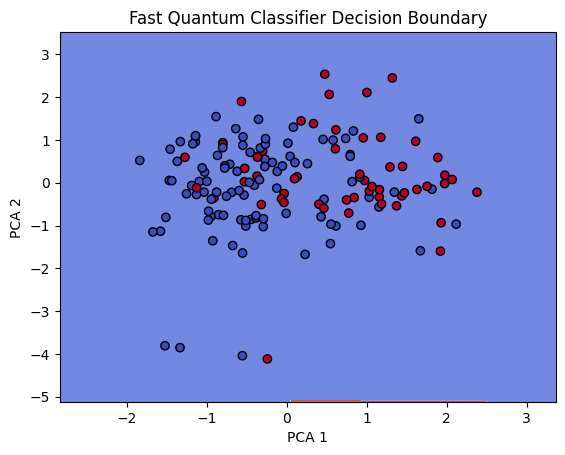

In [11]:
import matplotlib.pyplot as plt

# Increase step size to reduce points
h = 0.02
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Reduce number of points by sampling
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Limit to 500 grid points for quick visualization
max_points = 500
sampled_grid_points = grid_points[:max_points]

# Predict only on these points
Z = [quantum_classifier(weights, bias, point) for point in sampled_grid_points]
Z = (np.array(Z) > 0).astype(int)

# Fill in the grid manually
Z_full = np.zeros(xx.ravel().shape)
Z_full[:max_points] = Z
Z_full = Z_full.reshape(xx.shape)

plt.contourf(xx, yy, Z_full, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Fast Quantum Classifier Decision Boundary')
plt.show()


In [12]:
#Compare with Classical Model (Logistic Regression)
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_lr = clf.predict(X_test)

# Classical accuracy
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression accuracy: {acc_lr:.2f}")

Logistic Regression accuracy: 0.77


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define a simple MLP model
mlp = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp.compile(optimizer=Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

# Evaluate
loss, acc_mlp = mlp.evaluate(X_test, y_test, verbose=0)
print("MLP Accuracy:", acc_mlp)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MLP Accuracy: 0.7662337422370911


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", acc_rf)


Random Forest Accuracy: 0.7272727272727273


In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# === K-Nearest Neighbors ===
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", acc_knn)

# === Support Vector Machine ===
svm = SVC(kernel='linear')  # Try 'rbf' for non-linear
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", acc_svm)


KNN Accuracy: 0.7402597402597403
SVM Accuracy: 0.7727272727272727


In [20]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, InputLayer
from tensorflow.keras.optimizers import Adam

# Reshape tabular data for 1D CNN: (samples, features, channels)
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

# Define 1D CNN
cnn = Sequential([
    InputLayer(input_shape=(X_train.shape[1], 1)),
    Conv1D(16, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

cnn.compile(optimizer=Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model with accuracy tracking
history = cnn.fit(X_train_cnn, y_train, epochs=30, batch_size=16, validation_data=(X_test_cnn, y_test), verbose=0)

# Evaluate
loss, acc_cnn = cnn.evaluate(X_test_cnn, y_test, verbose=0)
print("CNN Accuracy:", acc_cnn)


CNN Accuracy: 0.7792207598686218


In [21]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
acc_xgb = accuracy_score(y_test, xgb.predict(X_test))
print("XGBoost accuracy:", acc_xgb)


XGBoost accuracy: 0.7207792207792207


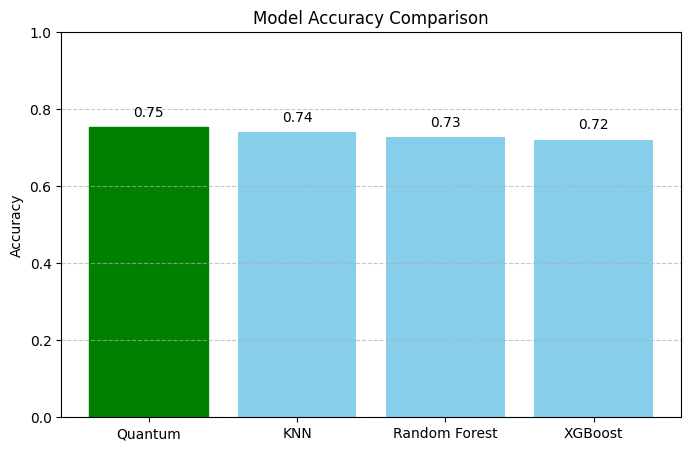

In [27]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Model names and accuracies
models = ['Quantum', 'KNN', 'Random Forest', 'XGBoost']
accuracies = [acc, acc_knn, acc_rf, acc_xgb]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color='skyblue')

# Highlight the highest accuracy
highest_acc = max(accuracies)
highest_index = accuracies.index(highest_acc)
bars[highest_index].set_color('green')

plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bar values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.show()